/var/folders/rd/2qtbwfgd19393jz_88zlxw440000gn/T/ipykernel_5884/3847608498.py:24: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(vec1, vec2))


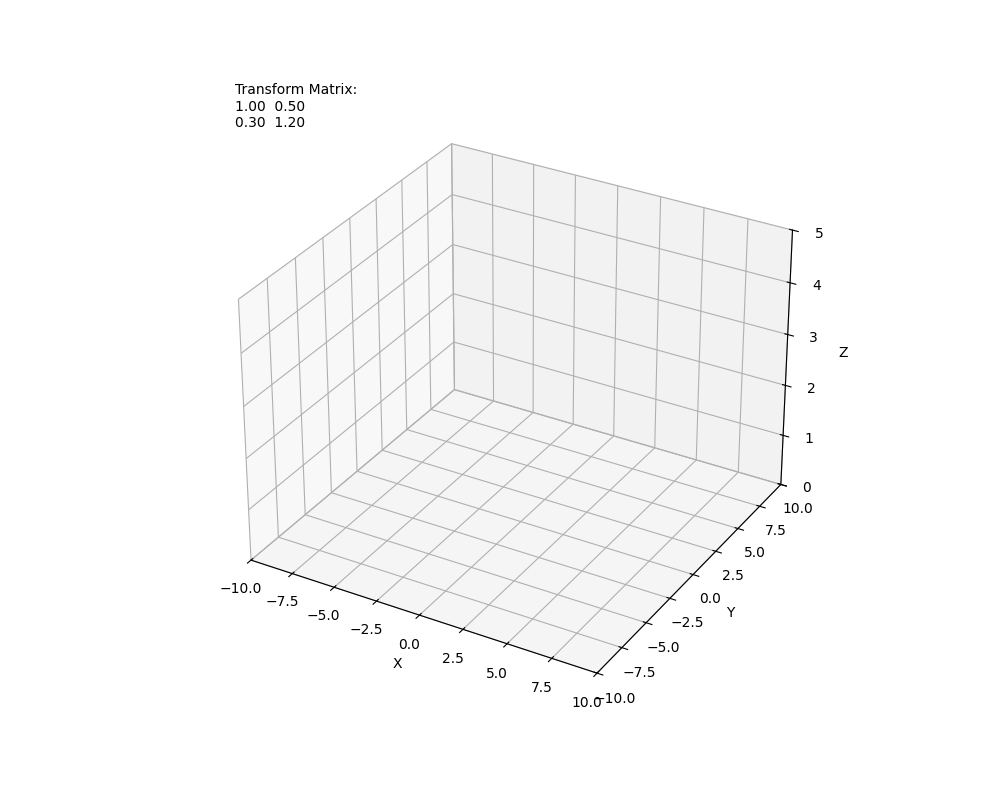

In [1]:
%matplotlib ipympl

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from scipy import linalg

# 設定
n = 11  # グリッドサイズ
frames = 40  # アニメーションフレーム数
interval = 125  # フレーム間隔
snapshot_interval_sec = 1  # スナップショット間隔


# クロス積を用いて面積を計算
# 平行四辺形であることが前提となる
# points: [[x,y], [x,y], ...]
def calc_area(points, n):
    origin = points[0]
    right = points[n - 1]
    bottom = points[n * (n - 1)]
    vec1 = np.array([right[0] - origin[0], right[1] - origin[1]])
    vec2 = np.array([bottom[0] - origin[0], bottom[1] - origin[1]])
    return np.abs(np.cross(vec1, vec2))


# nxnの2次元行列を作成
points = []
for i in range(n):
    for j in range(n):
        points.append([i - 5, j - 5])
points = np.array(points)
area = calc_area(points, n)

# 変換行列
transform_matrix = np.array(
    [
        [1, 0.5],
        [0.3, 1.2],
    ]
)


# プロット設定
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection="3d")

# 軸設定
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(0, 5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# グリッド設定
ax.grid(True)

# スナップショットと現在のフレームの散布図を初期化
snapshots = []
snapshot_plots = []
current_scatter = ax.scatter([], [], [], color="green")

# 固有ベクトルの矢印を初期化
eigenvector_arrows = [ax.quiver(0, 0, 0, 0, 0, 0) for _ in range(2)]


# テキスト表示用
text_matrix = ax.text2D(0.05, 0.95, "", transform=ax.transAxes)
text_area = ax.text2D(0.05, 0.90, "", transform=ax.transAxes)
text_det = ax.text2D(0.05, 0.85, "", transform=ax.transAxes)
text_eigen = ax.text2D(0.95, 0.95, "", transform=ax.transAxes)

# 変換行列のテキストを更新（これは変わらない固定値）
matrix_text = f"Transform Matrix:\n{transform_matrix[0,0]:.2f}  {transform_matrix[0,1]:.2f}\n{transform_matrix[1,0]:.2f}  {transform_matrix[1,1]:.2f}"
text_matrix.set_text(matrix_text)


# 固有ベクトルを計算
eigenvalues, eigenvectors = np.linalg.eig(transform_matrix)


# アニメーション更新関数
def update(frame):
    global snapshot_plots, current_scatter

    if frame == 0:
        # 初期化
        for snapshot_plot in snapshot_plots:
            snapshot_plot.remove()
        snapshot_plots.clear()

    msec = frame * interval
    powered = linalg.fractional_matrix_power(transform_matrix, msec / 1000)

    # 変換行列との積を求めて点を更新
    transformed = np.dot(points, powered.T)
    transformed_x = transformed[:, 0]
    transformed_y = transformed[:, 1]
    transformed_z = [msec / 1000] * len(transformed[:, 0])

    # 1秒ごとにスナップショットを追加
    if msec % (1000 * snapshot_interval_sec) == 0:
        snapshot_plot = ax.scatter(
            transformed_x, transformed_y, transformed_z, color="green", alpha=0.2
        )
        snapshot_plots.append(snapshot_plot)

    # 現在のフレームの散布図を更新
    current_scatter._offsets3d = (transformed_x, transformed_y, transformed_z)

    # 数値計算
    current_area = calc_area(transformed, n)
    determinant = np.linalg.det(powered)
    eigenvalues, eigenvectors = np.linalg.eig(transform_matrix)

    # テキスト更新
    text_area.set_text(f"Area: {area:.2f} -> {current_area:.2f}")
    text_det.set_text(f"Determinant: {determinant:.2f}")

    eigen_text = "Eigenvalues and Eigenvectors:\n"
    for i in range(2):
        eigen_text += f"λ{i+1} = {eigenvalues[i]:.2f}, v{i+1} = [{eigenvectors[0,i]:.2f}, {eigenvectors[1,i]:.2f}]\n"
    text_eigen.set_text(eigen_text)

    # 固有ベクトルの更新
    for i, (eigenvalue, eigenvector) in enumerate(zip(eigenvalues, eigenvectors.T)):
        # 固有ベクトルを現在の変換行列で変換
        transformed_eigenvector = np.dot(powered, eigenvector)

        # 固有ベクトルのスケールを調整（見やすくするため）
        scale = 5

        # 既存の矢印を削除
        eigenvector_arrows[i].remove()

        # 新しい矢印を描画
        eigenvector_arrows[i] = ax.quiver(
            0,
            0,
            msec / 1000,
            transformed_eigenvector[0] * scale,
            transformed_eigenvector[1] * scale,
            0,
            color=["b", "y"][i],
        )

    # すべてのプロットオブジェクトを返す
    return tuple(snapshot_plots + [current_scatter, text_det] + eigenvector_arrows)


# アニメーションを作成
anim = FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)

plt.show()
